In [1]:
import pandas
import itertools as it
lookup_table = pandas.read_csv("./legacy/valid_values.csv", sep = ";")

print(lookup_table[0:3])

   NumChickens FieldArea ItemSurfaceArea
0           21      5625           19,24
1           21   6944,44           19,24
2           21   8402,78           19,24


In [2]:
lookup_table.reset_index()
for i, data in lookup_table.iterrows():
    if i > 0:
        break
    print(i)
    print(data)
    

0
NumChickens           21
FieldArea           5625
ItemSurfaceArea    19,24
Name: 0, dtype: object


In [4]:
from typing import Tuple, List
import math
import numpy as np
def compute_canonical_parameters(n_chickens: int, field_area: float, chicken_size: float) -> Tuple[float, float, float, float]:
    FA = (((0.006) * math.sqrt(field_area))**2)*math.pi
    

def compute_nd_nnd_coords(trial_left: List[float], trial_right: List[float]) -> Tuple[float, float]:
    #formula specified by previous thesis writers
    #NND = (0.577+0.467∗Number)∗(FA/Number) +(0.487+0.473∗Number)∗ISA
    nnd_right = (0.577+0.467*trial_right[0])*(trial_right[1]/trial_right[0]) + (0.487+0.473*trial_right[0])*trial_right[2]
    nnd_left = (0.577+0.467*trial_left[0])*(trial_left[1]/trial_left[0]) + (0.487+0.473*trial_left[0])*trial_left[2]

    return np.log10(trial_right[0]/trial_left[0]), np.log10(nnd_right/nnd_left)

In [5]:
import random
data = {}
columns = ["Unnamed","NumLeft","FieldAreaLeft","ItemSurfaceAreaLeft","NumRight","FieldAreaRight","ItemSurfaceAreaRight","Ratio L/R","LogRatio","Log - Normalized","Difficulty Coefficient","Diff_coeff_filtering", "nd_LogRatio", "nnd_LogRatio"]

for c in columns:
    data[c] = []
i=0
for (ileft, dleft), (iright,dright) in it.combinations(lookup_table.sample(frac=1.0).iterrows(), 2):
    if dleft[0] == dright[0]:
        continue
    fAreaLeft = float(dleft[1].replace(",", "."))
    fAreaRight = float(dright[1].replace(",", "."))
    iAreaLeft = float(dleft[2].replace(",", "."))
    iAreaRight = float(dright[2].replace(",", "."))

    data["Unnamed"].append(i) 
    data["NumLeft"].append(dleft[0])
    data["FieldAreaLeft"].append(fAreaLeft)
    data["ItemSurfaceAreaLeft"].append(iAreaLeft)
    data["NumRight"].append(dright[0])
    data["FieldAreaRight"].append(fAreaRight)
    data["ItemSurfaceAreaRight"].append(iAreaRight)

    #nd and nnd coords, should be relevant for any kind of implemented ai 
    nd_logratio, nnd_logratio = compute_nd_nnd_coords([int(dleft[0]), fAreaLeft,iAreaLeft], [int(dright[0]), fAreaRight, iAreaRight])
    data["nd_LogRatio"].append(nd_logratio)
    data["nnd_LogRatio"].append(nnd_logratio)

    #old statistics, computed for backward compatibility
    data["Ratio L/R"].append(round((dleft[0]/dright[0]),2))
    data["LogRatio"].append(round(np.log10(round((dleft[0]/dright[0]),2)),2))
    data["Log - Normalized"].append(round(np.log10(round((dleft[0]/dright[0]),2)),2))
    data["Difficulty Coefficient"].append(round(random.uniform(0, 1), 2))
    data["Diff_coeff_filtering"].append(round(random.uniform(0,1), 2))


    #do the same for the specular trial
    data["Unnamed"].append(i) 
    data["NumLeft"].append(dright[0])
    data["FieldAreaLeft"].append(fAreaRight)
    data["ItemSurfaceAreaLeft"].append(iAreaRight)
    data["NumRight"].append(dleft[0])
    data["FieldAreaRight"].append(fAreaLeft)
    data["ItemSurfaceAreaRight"].append(iAreaLeft)

    #nd and nnd coords, should be relevant for any kind of implemented ai 
    nd_logratio, nnd_logratio = compute_nd_nnd_coords([int(dright[0]), fAreaRight,iAreaRight], [int(dleft[0]), fAreaLeft, iAreaLeft])
    data["nd_LogRatio"].append(nd_logratio)
    data["nnd_LogRatio"].append(nnd_logratio)

    #old statistics, computed for backward compatibility
    data["Ratio L/R"].append(round((dright[0]/dleft[0]),2))
    data["LogRatio"].append(round(np.log10(round((dright[0]/dleft[0]),2)),2))
    data["Log - Normalized"].append(round(np.log10(round((dright[0]/dleft[0]),2)),2))
    data["Difficulty Coefficient"].append(round(random.uniform(0, 1), 2))
    data["Diff_coeff_filtering"].append(round(random.uniform(0,1), 2))

    

In [6]:
new_table = pandas.DataFrame(data = data, columns=columns)
print(new_table)

       Unnamed  NumLeft  FieldAreaLeft  ItemSurfaceAreaLeft  NumRight  \
0            0        9       13611.11               173.13        21   
1            0       21       10000.00                27.70         9   
2            0        9       13611.11               173.13         5   
3            0        5        8402.78               196.98         9   
4            0        9       13611.11               173.13         1   
...        ...      ...            ...                  ...       ...   
55673        0       21       17777.78                76.95         9   
55674        0        9       17777.78               196.98        37   
55675        0       37       22500.00                37.70         9   
55676        0       21       17777.78                76.95        37   
55677        0       37       22500.00                37.70        21   

       FieldAreaRight  ItemSurfaceAreaRight  Ratio L/R  LogRatio  \
0            10000.00                 27.70       0.43 

In [52]:
# additional processing for backward compatibility
def diff_coef(i, x, y):
    try:
        if (x > 0 and y >= 0) or (x < 0 and y <= 0):
            k = math.atan(y/x)
        elif (x < 0 and y >= 0) or (x > 0 and y <= 0):
            k = math.pi - abs(math.atan(y/x))
        a = math.degrees(abs((math.pi/4)-k))
    except:
        return -1
    return a

#i think it's wrong normalizing and making decisions on normalized values,
#adding new trials can change the whole feature space, we are losing coherency with respect to Learning to Focus on Numbers
new_table["Log - Normalized"] = round(new_table["Log - Normalized"]/new_table["Log - Normalized"].max(),2).abs()
new_table["Difficulty Coefficient"] = round(1- new_table["Log - Normalized"],2)

max_nd = new_table['nd_LogRatio'].abs().max()
max_nnd = new_table['nnd_LogRatio'].abs().max()

filtering_diff = []
for i, row in new_table.iterrows():
    filtering_diff.append(diff_coef(i,row["nd_LogRatio"]/max_nd, row["nnd_LogRatio"]/max_nnd))

new_table["Diff_coeff_filtering"] = filtering_diff
new_table["Diff_coeff_filtering"] = new_table["Diff_coeff_filtering"]/new_table["Diff_coeff_filtering"].max()




In [53]:
import os
if os.path.exists("lookup_table.csv"):
    os.remove("lookup_table.csv")
new_table.to_csv("./lookup_table.csv")

# Some analysis and ad hoc computations

In [9]:
import pandas
lookup_table = pandas.read_csv("./lookup_table.csv")

print(lookup_table['nd_LogRatio'].min())
print(lookup_table['nd_LogRatio'].max())
print(lookup_table['nnd_LogRatio'].min())
print(lookup_table['nnd_LogRatio'].max())
#highest = lookup_table.iloc((lookup_table['nd_LogRatio']).abs().argsort()[:1])

-2.004321373782642
2.049218022670181
-0.8816194191065028
0.8542775057372487


In [10]:
okay = False
count = 0
count_two=0
for row in lookup_table.iterrows():
    row=row[1]
    if row["nd_LogRatio"] >0 and row["nnd_LogRatio"]<0:
        #print(row)
        okay = True
        #assert False == True
        count+=1
    if row["nd_LogRatio"] <0 and row["nnd_LogRatio"]>0:
        count_two +=1

print(okay)
print(count)
print(count_two)

True
4876
4158


In [11]:
max_nd = lookup_table['nd_LogRatio'].abs().max()
max_nnd = lookup_table['nnd_LogRatio'].abs().max()

lookup_table['nd_LogRatio'] = lookup_table['nd_LogRatio'].abs()/max_nd
lookup_table['nnd_LogRatio'] = lookup_table['nnd_LogRatio'].abs()/max_nnd

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def myHistogram(data: np.ndarray,n_labels:int,labels:np.ndarray, bins: int=20):
    colors = ["red", "green", "blue","orange" , "gray", "orange"]

    for i in range(0,data.shape[0]):
        for j in range(0,n_labels):
            plt.hist(data[i, labels == j],bins=bins, density=True, color=colors[j],alpha=0.6, histtype='bar', rwidth=0.9)
        plt.show()

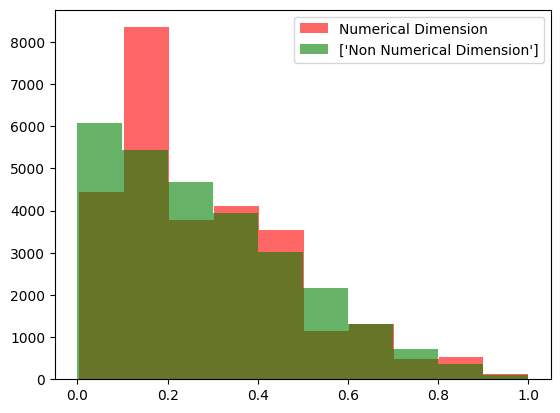

In [13]:
nd_logratio = lookup_table["nd_LogRatio"]
nnd_logratio = lookup_table["nnd_LogRatio"]

nd =plt.hist(nd_logratio, color="red", histtype='bar', alpha=0.6)
nnd =plt.hist(nnd_logratio, color = "green",  histtype='bar', alpha=0.6)

plt.legend(["Numerical Dimension", ["Non Numerical Dimension"]])

plt.show()

In [3]:
import pandas
import math
def diff_coeff(i, x, y):
    
    if (x > 0 and y >= 0) or (x < 0 and y <= 0):
            k = math.atan(y/x)
    elif (x < 0 and y >= 0) or (x > 0 and y <= 0):
        k = math.pi - abs(math.atan(y/x))
    a = math.degrees(abs((math.pi/4)-k))
    
    return a

new_table = pandas.read_csv("./lookup_table.csv")

max_nd = new_table['nd_LogRatio'].abs().max()
max_nnd = new_table['nnd_LogRatio'].abs().max()
print(diff_coeff(1, 0.3, 0.2))
print(diff_coeff(1, -0.3, 0.2))

11.309932474020208
101.3099324740202


In [2]:
import numpy as np

import matplotlib.pyplot as plt
from typing import List, Any, Callable

def to_mock_trial(nd: float, nnd: float):
    return [-1,-1,-1,-1,-1,-1,-1,-1,nd, nnd]

def plot_trials(boundary_vector: np.ndarray, trials: List[List[Any]], corrects: List[bool], annotations: List[float], ann_str: bool = False, plot_stats: Callable = None, plot_dist: bool = False):

    fig, ax= plt.subplots(1,1)
    #ax = fig.axes
    
    vec= 5*boundary_vector
    
    plt.plot([vec[0], -vec[0]], [vec[1], -vec[1]])

    colors = {True: 'green', False: 'red'}

    coords = list(map(lambda x: x[8:],trials))
    
    
    for i, coord in enumerate(coords):
        #print(corrects[i])
        plt.scatter(coord[0], coord[1], color = colors[corrects[i]])
        #ax.text(coord[0]-0.1, coord[1]+0.1, str(round(times[i],2)), color = colors[corrects[i]])

        if ann_str:
            plt.annotate(annotations[i], (coord[0], coord[1]), color= "red")
        else:    
            ax.annotate(str(round(annotations[i],2)), (coord[0], coord[1]), color="red")
        #print(f">>{coord}")
        if plot_dist:
            coord = np.array(coord)
            proj = np.dot(boundary_vector, coord)
            proj = boundary_vector*proj
            ax.plot([proj[0], coord[0]], [proj[1], coord[1]], color="red")
        
    if plot_stats is not None:
        plot_stats(plt)

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    plt.xlim([-1, 1])
    plt.ylim([-1,1])
    #fig.supxlabel("Numerical dimension", loc="left")
    #fig.supylabel("Non numerical dimension", loc="bottom")
    plt.grid(True)

    plt.show()

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

In [39]:
import pandas
import math
#from ..AI.ai_plot import plot_trials

lookup_table = pandas.read_csv("./lookup_table.csv")

max_nd = lookup_table['nd_LogRatio'].abs().max()
max_nnd = lookup_table['nnd_LogRatio'].abs().max()

col = "Diff_coeff_filtering"
fetched_samples = 1

target_main_diff = 0.95
hard = lookup_table.iloc[(lookup_table[col]-target_main_diff).abs().argsort()[:fetched_samples]]

target_main_diff = 0.01
easy = lookup_table.iloc[(lookup_table[col]-target_main_diff).abs().argsort()[:fetched_samples]]

hard_diff = round(float(hard[col]),2)
easy_diff = round(float(easy[col]),2) 

hard = to_mock_trial(float(hard['nd_LogRatio'])/max_nd, float(hard['nnd_LogRatio'])/max_nnd)
easy = to_mock_trial(float(easy['nd_LogRatio'])/max_nd, float(easy['nnd_LogRatio'])/max_nnd)


print(hard)
print(easy)


[-1, -1, -1, -1, -1, -1, -1, -1, 0.16152171968999773, -0.019157591756252097]
[-1, -1, -1, -1, -1, -1, -1, -1, 0.21652039671921489, 0.2065593268881325]


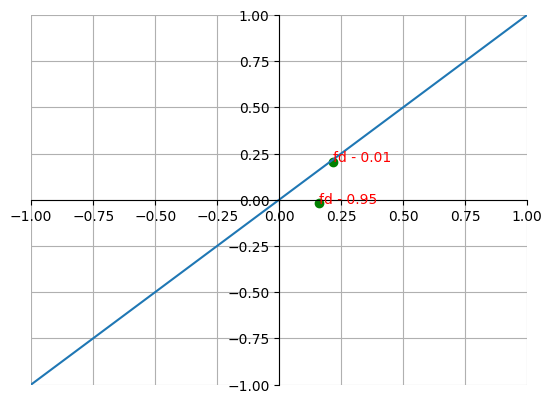

In [77]:
trials = [hard, easy]

corrects = [True, True]
anns = [f"fd - {hard_diff}", f"fd - {easy_diff}"]

plot_trials([1, 1], trials, corrects, anns, ann_str=True)

In [75]:
import numpy as np
col = "Difficulty Coefficient"
fetched_samples = 1

x = np.linspace(0.2, 0.8, 5)

trials = []
corrects = []
anns = []

for sd in x:
    target_main_diff = sd
    trial = lookup_table.iloc[(lookup_table[col]-target_main_diff).abs().argsort()[:fetched_samples]]
    diff = round(float(trial[col]),2)

    trials.append(to_mock_trial(float(trial['nd_LogRatio'])/max_nd, float(trial['nnd_LogRatio'])/max_nnd))
    corrects.append(True)
    anns.append(f"sd - {round(float(trial[col]),2) }")

print(easy)

[-1, -1, -1, -1, -1, -1, -1, -1, 0.21652039671921489, 0.2065593268881325]


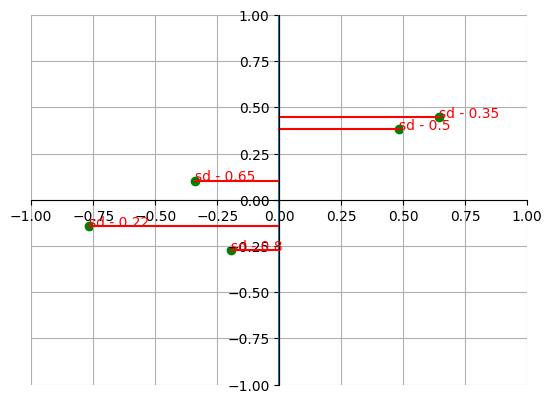

In [76]:


plot_trials(np.array([-0, 1]), trials, corrects, anns, ann_str=True, plot_dist=True)

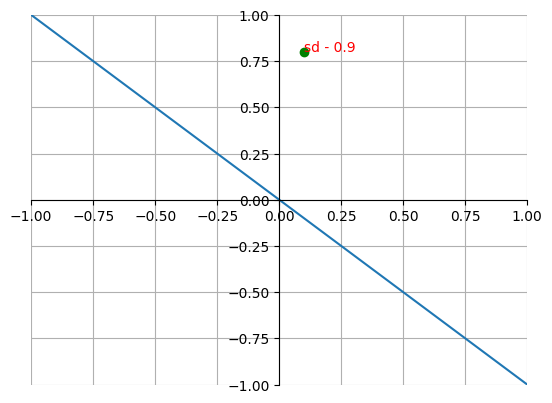

In [86]:
trials = [to_mock_trial(0.1, 0.8)]
corrects = [True]
anns = ["sd - 0.9"]
plot_trials(np.array([-1, 1]), trials, corrects, anns, ann_str=True)

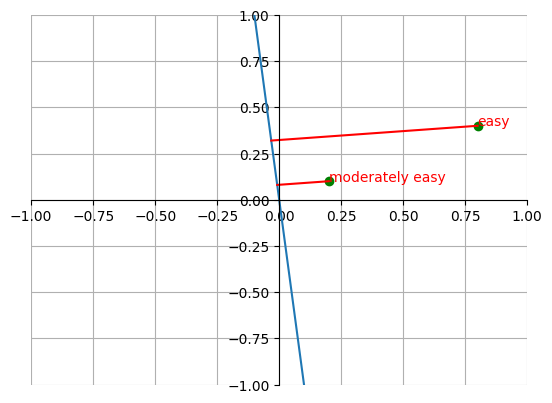

In [98]:
trials = [to_mock_trial(0.8, 0.4), to_mock_trial(0.2, 0.10)]
corrects = [True, True]
anns = ["easy", "moderately easy"]
plot_trials(np.array([-0.1, 1]), trials, corrects, anns, ann_str=True, plot_dist=True)

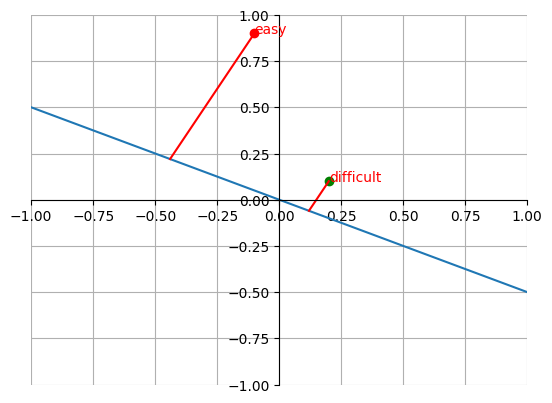

In [96]:
trials = [to_mock_trial(-0.1, 0.9), to_mock_trial(0.2, 0.10)]
corrects = [False, True]
anns = ["easy", "difficult"]
plot_trials(unit_vector(np.array([-2, 1])), trials, corrects, anns, ann_str=True, plot_dist=True)

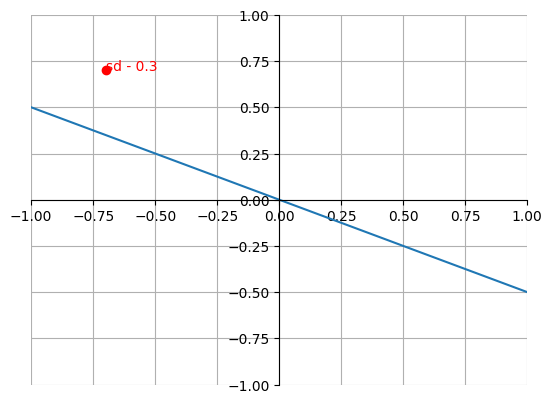

In [5]:
trials = [to_mock_trial(-0.7, 0.7)]
corrects = [False]
anns = ["sd - 0.3"]
plot_trials(unit_vector(np.array([-2, 1])), trials, corrects, anns, ann_str=True, plot_dist=False)